### Стабилизация обратного маятника



#### Задача 1

1) реализуем стабилизирующее управление
2) добавим ограничение по моменту

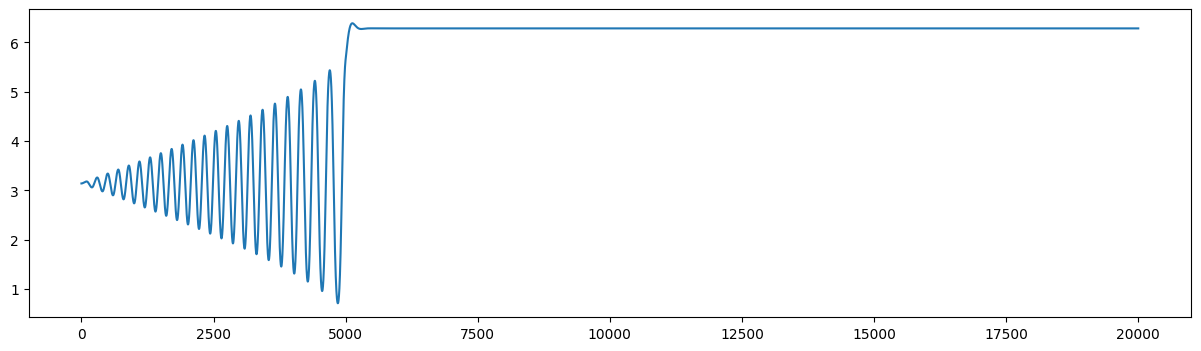

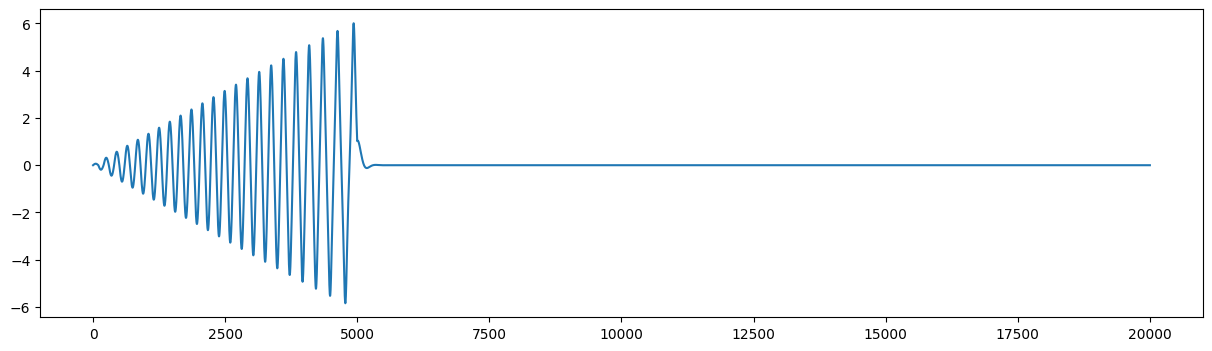

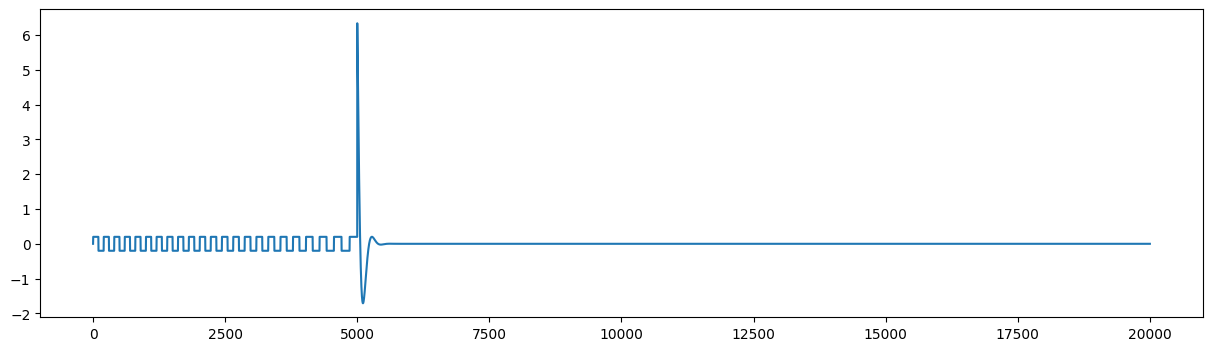

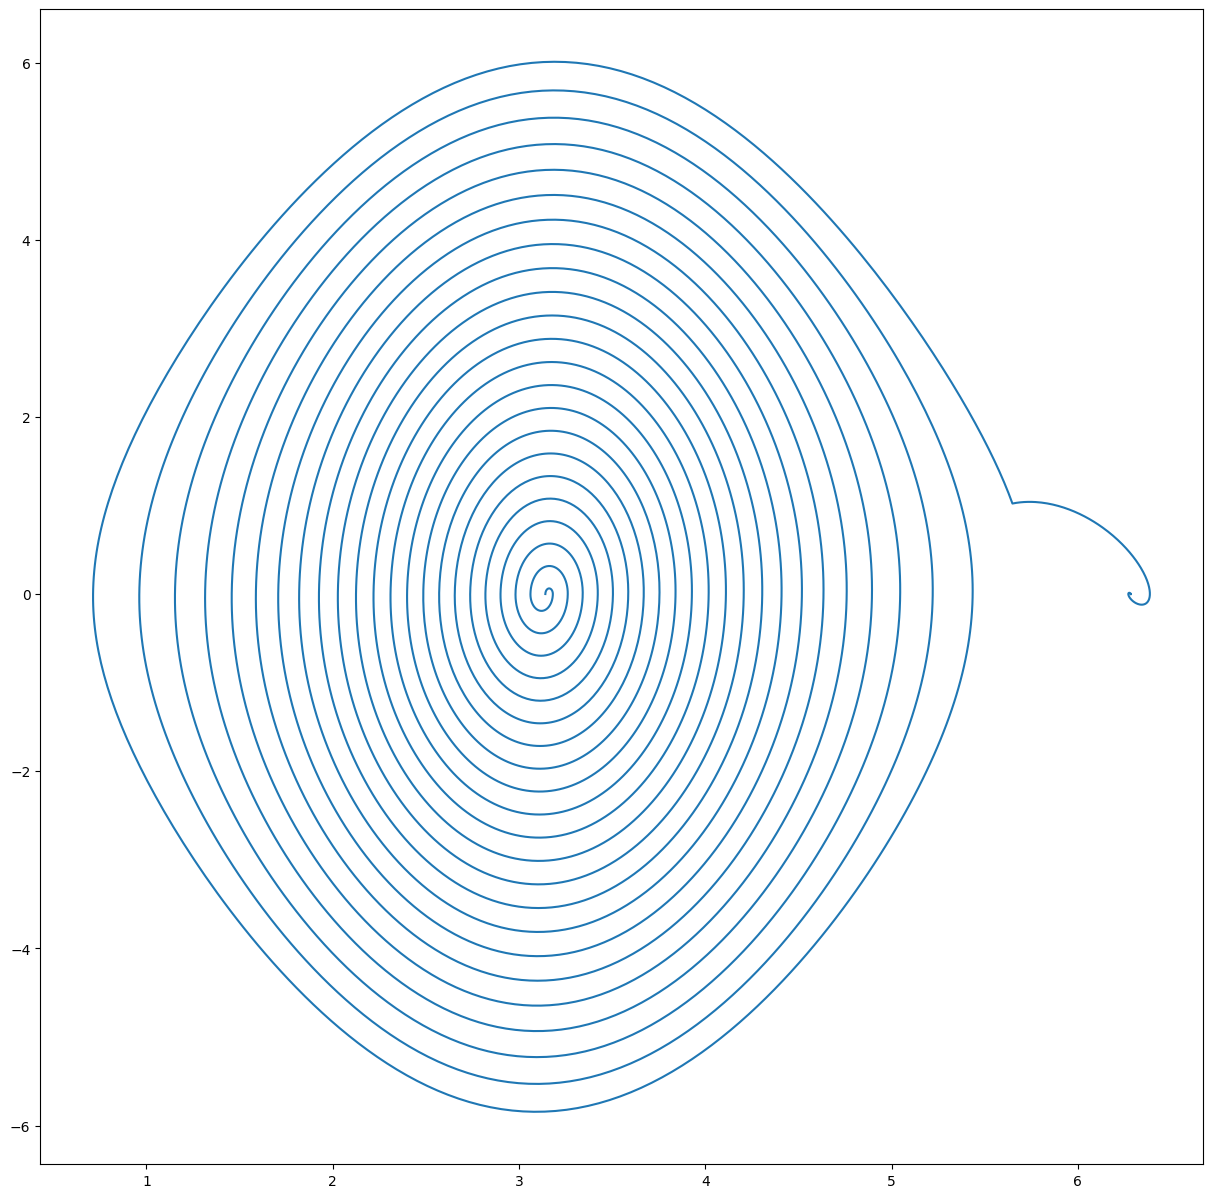

In [51]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, clear_output

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

class Pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.01, max_torque = 3):
        self.m = m
        self.l = l
        self.g = g
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        self.max_torque = max_torque
        
    def get_state(self):
        return self.x
    
    def sys_dyn(self, u_scalar):
        x_dot = np.zeros_like(self.x)
        
        u_effective = np.clip(u_scalar, - self.max_torque, self.max_torque)
                
        x_dot[0, 0] = self.x[1, 0]
        x_dot[1, 0] = self.g / self.l * np.sin(self.x[0, 0]) + u_scalar / (self.m * self.l**2)
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):        
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = -1
    
    if (inverted == True):
        direction = 1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def run_pendulum(x0, iter_num, visualize, control_function, max_torque = 3, dt = 0.01):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
        
    pendulum = Pendulum(x0 = x0, dt = dt)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = pendulum.get_state()

        control = control_function(state, max_torque)
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0, 0], (123, 234, 45), inverted = False)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj

def stabilizing_control(x, max_tau = 5):
    u = - 15 * x[0, 0] - 2.5 * x[1, 0]
    
    return u

def destabilizing_control(x, max_tau = 5):
    u = 2.5 * x[1, 0]
    
    return u

def swing_up_control(x, max_tau = 5):
    u = 0.2 * np.sign(x[1, 0])
    
    if (np.cos(x[0, 0]) > 0.8):
        #u = - 15 * x[0, 0] - 2.5 * x[1, 0]
        u = - 15 * np.sin(x[0, 0]) - 2.5 * x[1, 0]
    
    return u

def one_control_to_rule_them_all(x, max_tau = 5):
    return - np.sin(x[0, 0])

#x_hist, v_hist, u_hist = run_pendulum(x0 = 3.0, iter_num = 10000, visualize = False, control_function = lambda i, j : 3, max_torque = 3)
x_hist, v_hist, u_hist = run_pendulum(x0 = 3.1415, iter_num = 20000, visualize = False, control_function = swing_up_control, max_torque = 3, dt = 0.01)

plot_1d(x_hist)
plot_1d(v_hist)
plot_1d(u_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, v_hist)
plt.show()
clear_output(wait = True)

#### Задача 2

Посмотрим на контроллеры для динамических систем с одной степенью свободы как на функции $u: \mathbb{R}^2 \rightarrow \mathbb{R}$

1) стабилизируем маятник в нижнем положении равновесия
2) раскачаем маятник посильнее
3) применим случайное управление
4) придумаем управление, стабилизирующее маятник, из комбинации 2 и 3

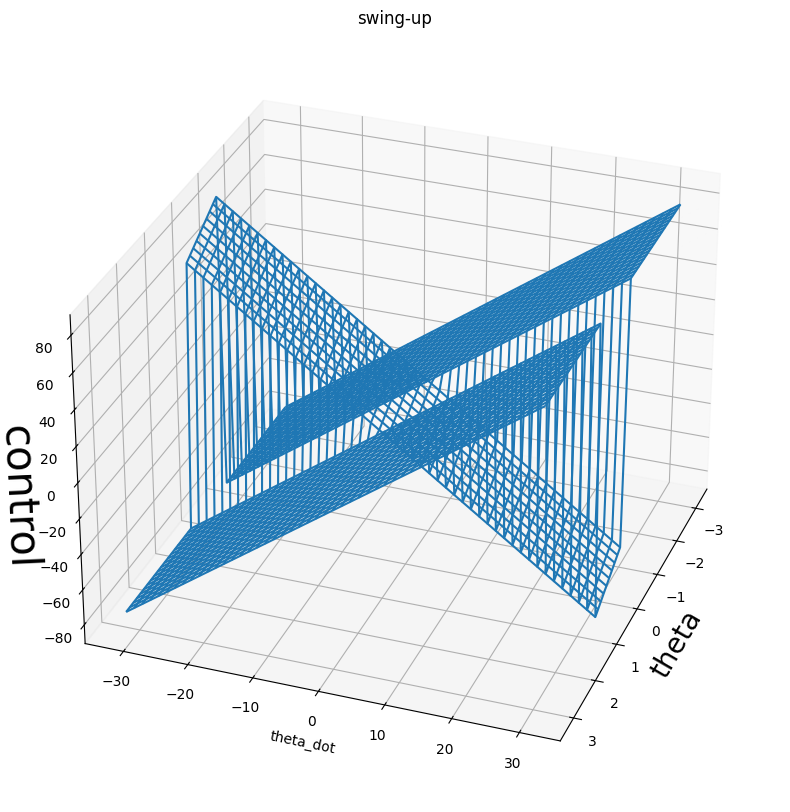

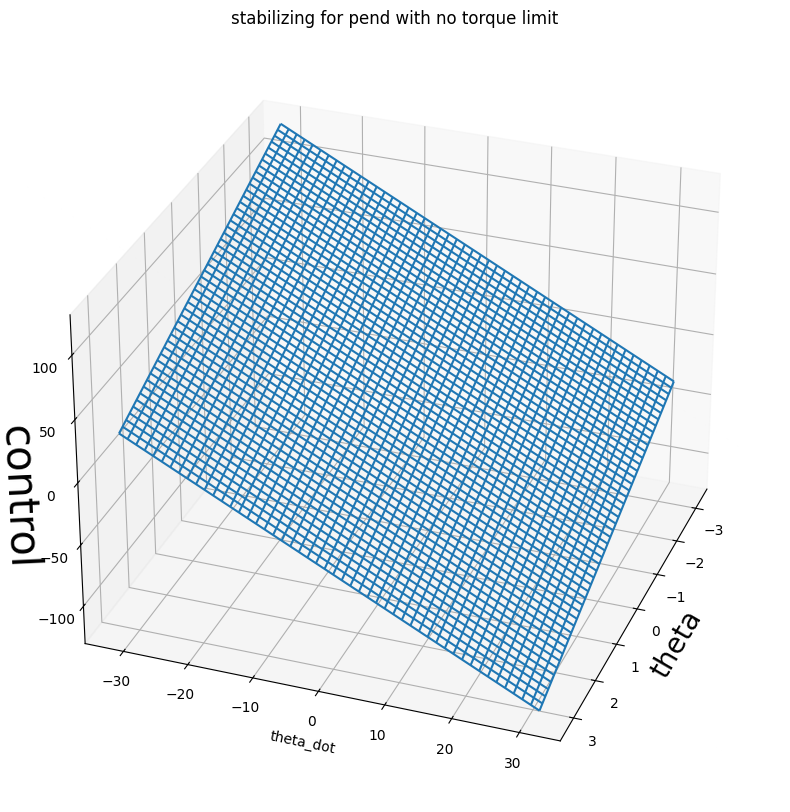

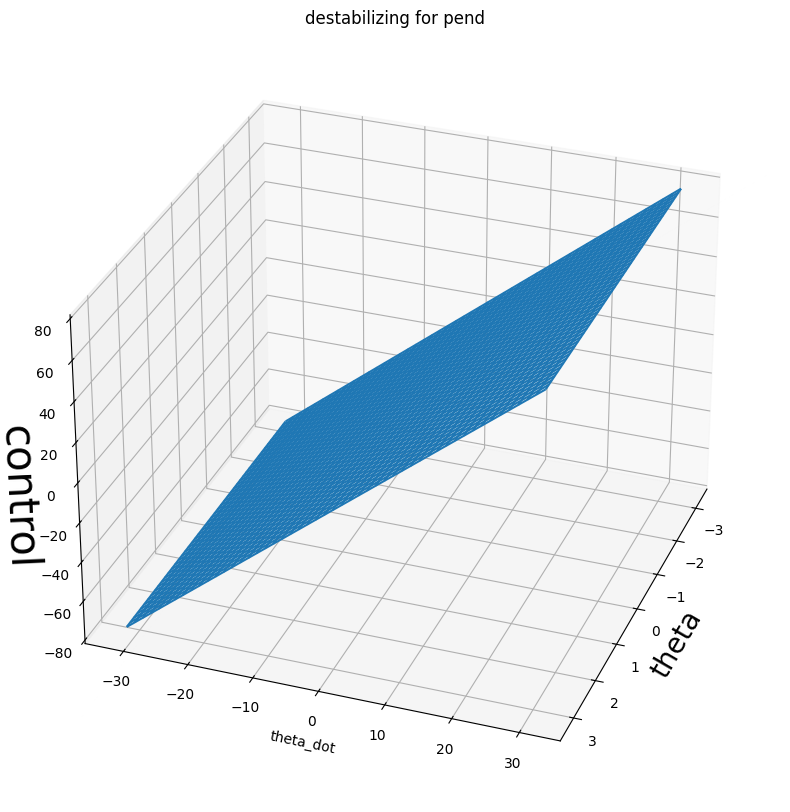

In [35]:
def constant_feedback(x, max_tau = 5):
    u = 3

    return u

# def stabilizing_control_(x):
#     u = - 15 * x[0, 0] - 2.5 * x[1, 0]
    
#     return u

# def destabilizing_control_(x):
#     u = 0.5 * x[1, 0]
    
#     return u

def visualize_function_3D(function, llim1, hlim1, a1name,
                          llim2, hlim2, a2name, pnum, clipvalue = 100000, title = ""):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(llim1, hlim1, num = pnum)
    Y = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X, Y)

    Z = X**2 + Y**2
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X[i, j]
            y = Y[i, j]

            t = function(np.array([[x], [y]]), )
            
            t = np.clip(t, -clipvalue, clipvalue)
            
            Z[i, j] = t
    
    ax.view_init(30, 20)
    ax.plot_wireframe(X, Y, Z)
    
    ax.set_title(title)

    ax.set_xlabel(a1name, fontsize=20, rotation=150)
    ax.set_ylabel(a2name)
    ax.set_zlabel(r'control', fontsize=30, rotation=60)
        
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))

feedbacks = {#"constant feedback" : constant_feedback,
             "swing-up" : swing_up_control,
             "stabilizing for pend with no torque limit" : stabilizing_control,
             "destabilizing for pend" : destabilizing_control}

for feedback_name, feedback in feedbacks.items():
    visualize_function_3D(feedback, -math.pi, math.pi,
        "theta", -5 * math.pi * 2, 5 * math.pi * 2, "theta_dot", 50, title = feedback_name)

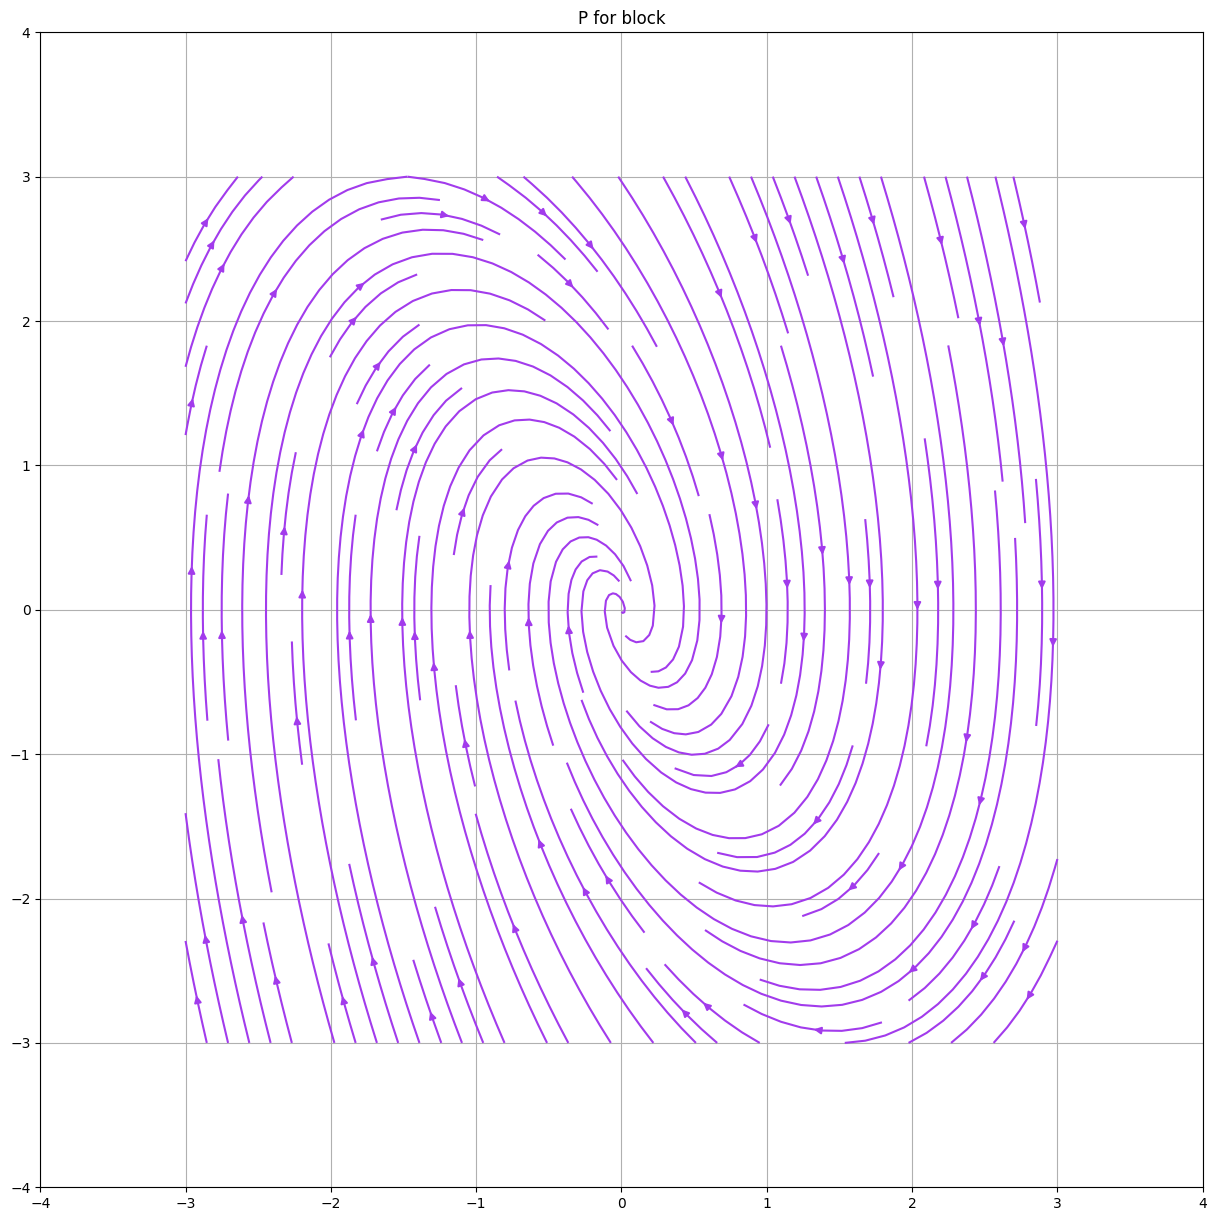

: 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

def visualize_system_evolution(dynamics, controller, llim1 = -3, hlim1 = 3, a1name = "x",
                          llim2 = -3, hlim2 = 3, a2name = "x_dot", pnum = 30, clipvalue = 100000, title = ""):
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    
    X_linsp = np.linspace(llim1, hlim1, num = pnum)
    Y_linsp = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X_linsp, Y_linsp)

    
    U, V = np.meshgrid(X_linsp, Y_linsp)
    
    for i in range(pnum):
        for j in range(pnum):
            x = X[i, j]
            y = Y[i, j]

            state = np.array([[x], [y]])
            control = controller(state)
            x_dot = dynamics(state, control)
            
            U[i, j] = x_dot[0, 0]
            V[i, j] = x_dot[1, 0]
        
    plt.streamplot(X, Y, U, V, density=1.4, linewidth=None, color='#A23BEC') 

    plt.title(title)
    
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

    plt.grid()
    plt.show()

def inverted_pendulum_dynamics(state, u_scalar):
    tau_max = 2
    g = 1
    l = 1
    m = 1
    
    u_effective = np.clip(u_scalar, -tau_max, tau_max)

    x_dot = np.zeros_like(state)

    x_dot[0, 0] = state[1, 0]
    x_dot[1, 0] = g / l * np.sin(state[0, 0]) + u_effective / (m * l**2)

    return x_dot

def block_dynamics(state, u_scalar):
    m = 1
    
    x_dot = np.zeros_like(state)

    x_dot[0, 0] = state[1, 0]
    x_dot[1, 0] = u_scalar / m

    return x_dot

def P_feedback(state):
    return - 3 * state[0, 0] - 1.5 * state[1, 0]

experiments = [(block_dynamics, P_feedback, "P for block"),]
               #(block_dynamics, PD_feedback, "PD for block"),
               #(block_dynamics, random_feedback, "random for block"),
               #(inverted_pendulum_dynamics, energy_based_feedback, "energy-based for pendulum"),
               #(inverted_pendulum_dynamics, swing_up_feedback, "swing-up for pendulum")]

for (dynamics, feedback, title) in experiments:
    visualize_system_evolution(dynamics, feedback, title = title)